# Bayesian Deep Learning in Push

## Introduction

In this notebook, we will demonstrate various features of Push by using it to train a **deep ensemble** on a synthetic sine wave datasat generated as below:

$$
\begin{align}
    y & = sin(x) + \epsilon \\
    \epsilon & \sim \mathcal{N}(0, 0.05) \,.
\end{align}
$$

A deep ensemble is one of many methods for performing **Bayesian deep learning** (BDL). BDL applies **Bayesian inference** to neural networks (NNs) in order to bring the benefits of Bayesian inference to deep learning (DL) such as **uncertainty quantification**. For more background on BDL, we recommend Kevin Murphy's book "Probabilistic Machine Learning: Advanced Topics, Kevin Murphy, Chapter 17" on BDL [1].

### Setting up the Dataset

We begin by creating the sine wave dataset with $D = 1$ dimensions defined on the interval $(-2\pi, 2\pi)$ with $N = 2048$ data points.

In [1]:
import math
import torch
from torch.utils.data import Dataset
from experiments.nns.bdl import SineWithNoiseDataset
from experiments.nns.bdl import SineDataset


# Define the dataset as a PyTorch dataset
# class SineWithNoiseDataset(Dataset):
#     def __init__(self, N, D, begin, end, noise_std=1):
#         self.xs = torch.linspace(begin, end, N).reshape(N, D)
#         true_ys = torch.sin(self.xs[:, 0]).reshape(-1, 1)
#         mean = torch.zeros(true_ys.size()[0])
#         std = torch.exp(torch.linspace(torch.log(noise_std), torch.log(4 * noise_std), true_ys.size()[0]))
#         noise = torch.normal(mean, std).view(-1, 1)
#         self.ys = true_ys + noise

#     def __len__(self):
#         return len(self.xs)

#     def __getitem__(self, idx):
#         return self.xs[idx], self.ys[idx]

D = 1                                  # dimensions
N = 128                               # number of points
train_begin_radians = -0.5 * math.pi     # left interval
train_end_radians =  0.5 * math.pi        # right interval
dataset = SineWithNoiseDataset(N, D, train_begin_radians, train_end_radians)
normal_dataset = SineDataset(N, D, train_begin_radians, train_end_radians)

### Plotting the Dataset 

We visualize the sine wave dataset `dataset` below.

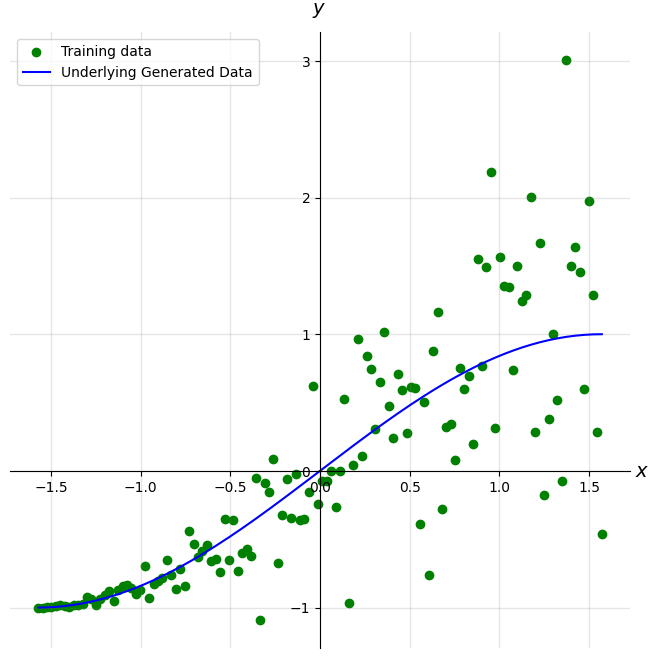

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(dataset.xs, dataset.ys, c ='green', label="Training data")
ax.plot(normal_dataset.xs, normal_dataset.ys, c = "blue", label="Underlying Generated Data")
ax.plot()
ax.legend()
plt.xlabel('Input X')
plt.ylabel('Target Y')
# ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin-1, ymax+1), aspect='equal')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.set_xlabel('$x$', size=14, labelpad=-24, x=1.02)
ax.set_ylabel('$y$', size=14, labelpad=-21, y=1.02, rotation=0)
ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)
# ax.xlim(train_begin_radians, train_end_radians)
# ax.ylim(-1.5, 1.5)
plt.show()

## Defining Models in Push with Particles

Users can represent a Bayesian neural network (BNN) in Push as a **concurrently-executing** and **communicating** ensemble of **particles**. This consists of two components.

1. Push provides functionality to wrap an arbitrary PyTorch module as a **particle**. This enables Push users to use a wide range of predefined models.
2. Push enables orchestrating ensembles of particles, concurrent execution of particles, and communications between particles using the `PusH` construct. This enables Push users to easily implement concurrent Bayesian inference algorithms on multiple devices. Additionally, Push supplies various off-the-shelf inference algorithms.

### Model Part 1: Neural Network Architecture Template

For the purposes of this tutorial, we introduce a simple neural network (NN) model now. This NN architecture will be used as a template to create instances of particles. The model is comprised of two components.
1. Each `MiniNN` contains two fully-connected layers of dimension $D$ and uses a ReLU activation function.
2. A `BiggerNN` is built out of $n$ `MiniNN` NN blocks.
In general, an arbitrary PyTorch model can be used. 

In [3]:
import torch.nn as nn

class MiniNN(nn.Module):
    def __init__(self, D):
        super(MiniNN, self).__init__()
        self.fc1 = nn.Linear(D, D)
        self.fc2 = nn.Linear(D, D)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.ReLU()(x)
        x = self.fc2(x)
        return x
    
class BiggerNN(nn.Module):
    def __init__(self, n, input_dim, output_dim, hidden_dim):
        super(BiggerNN, self).__init__()
        self.minis = []
        self.n = n
       
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        for i in range(0, n):
            self.minis += [MiniNN(hidden_dim)]
            self.add_module("mini_layer"+str(i), self.minis[-1])
        self.fc = nn.Linear(hidden_dim, output_dim)
            
    def forward(self, x):
        x = self.input_layer(x)
        for i in range(0, self.n):
            x = self.minis[i](x)
        return self.fc(x)

In [4]:
# import torch.nn as nn

# class MiniNN(nn.Module):
#     def __init__(self, D):
#         super(MiniNN, self).__init__()
#         self.fc1 = nn.Linear(D, D)
#         self.fc2 = nn.Linear(D, D)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = torch.nn.ReLU()(x)
#         x = self.fc2(x)
#         return x
    
# class BiggerNN(nn.Module):
#     def __init__(self, n, input_dim, output_dim, hidden_dim):
#         super(BiggerNN, self).__init__()
#         self.minis = []
#         self.n = n
       
#         self.input_layer = nn.Linear(input_dim, hidden_dim)
#         for i in range(0, n):
#             self.minis += [MiniNN(hidden_dim)]
#             self.add_module("mini_layer"+str(i), self.minis[-1])
#         self.dropout = nn.Dropout(p=0.2)
#         self.fc = nn.Linear(hidden_dim, output_dim)
            
#     def forward(self, x):
#         x = self.input_layer(x)
#         for i in range(0, self.n):
#             x = self.minis[i](x)
#         return self.fc(self.dropout(x))

### Model Part 2: Ensemble of Particles

The construct `PusH` enables Push users to orchestrate a concurrent and communicating ensemble of particles. This means that each particle has its own logical thread of execution and can coordinate with other particles to perform computations. We give an example of calling `PusH` with the arguments below now.

1. `BiggerNN`: the NN architecture used as a template to create particles.
2. `*args`: the hyperparameters for the NN architecture. For a `BiggerNN`, this includes the number of `MiniNN` layers, the size of the input dimension, the size of the output dimension, and the size of the hidden dimension.

In [5]:
import push.push
from push.bayes.ensemble import mk_optim
from push.bayes.ensemble import mk_scheduler

args = [           # BiggerNN arguments
    4,             # number of layers
    1,             # input dimension
    1,             # output dimension
    32             # hidden dimension
]
num_ensembles = 4

# Create a communicating ensemble of particles using BiggerNN(*args) as a template.
with push.push.PusH(BiggerNN, *args) as push_dist:
    pids = []
    for i in range(num_ensembles):
        # 1. Each particle has a unique `pid`.
        # 2. `mk_optim` is a particle specific optimization method as in standard PyTorch.
        # 3. Create a particle on device 0.
        # 4. `receive` determines how each particle .
        # 5. `state` is the state associated with each particle.
        pids += [push_dist.p_create(mk_optim, mk_scheduler, device=0, receive={}, state={})]

## Training Models in Push

After we have defined a `PusH` object, we can use the orchestration capabilities of Push to train each particle, possibly with interaction between different particles during training. In this tutorial, we choose one of the simplest methods--deep ensembles--where there is no communication between different particles.

### Training Deep Ensembles in Push

A deep ensemble with $k$ ensembles trains $k$ instances of a NN architecture to obtains $k$ independently-trained models. Each trained model can be interpreted as the parameter setting corresponding to a sample from a suitably defined posterior distribution on NN parameters. In this way, a deep ensemble can be seen as a BDL method. To train a deep ensemble in Push, we use an implementation of an `Ensemble` object provided by Push in `push.bayes.ensemble`. The `Ensemble` object encapsulates a communicating and concurrently executing ensemble of particles.

In [6]:
from push.bayes.ensemble import Ensemble
from push.bayes.swag import MultiSWAG

# 1. `BiggerNN` is a NN template
# 2. `args` contains the hyper-parameters of `BiggerNN`.
ensemble = Ensemble(BiggerNN, *args, num_devices=2)
mswag = MultiSWAG(BiggerNN, *args, num_devices=2)

We can peform Bayesian inference on an `Ensemble` with the `bayes_infer` method. This method requires:

1. A **dataloader** (`torch.utils.data`).
2. A number of **epochs** to train for (`int`).
3. An optional **loss** function (`torch.nn.MSELoss`) for training.
4. The number of **ensembles** (`int`).

In this example, we will be using 2 ensembles.

In [7]:
from torch.utils.data import DataLoader

# 1. Create dataloader
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
epochs = 1000

# 2. Perform Bayesian inference
ensemble.bayes_infer(dataloader, epochs, loss_fn=torch.nn.MSELoss(), num_ensembles=16)
sixteen_particle_ensemble = ensemble

TypeError: Ensemble.bayes_infer() got an unexpected keyword argument 'num_devices'

In [8]:
import push.bayes.swag
# def bayes_infer(self,
#                     dataloader: DataLoader,
#                     pretrain_epochs: int, swag_epochs: int,
#                     loss_fn: Callable = torch.nn.MSELoss(),
#                     num_models: int = 1, cov_mat_rank: int = 20,
#                     mswag_entry=_mswag_particle, mswag_state={}, f_save=False,
#                     mswag_sample_entry=_mswag_sample_entry, mswag_sample=_mswag_sample):

pretrain_epochs = int(.7 * epochs)
swag_epochs = int(.3 * epochs)
mswag.bayes_infer(dataloader, pretrain_epochs, swag_epochs, torch.nn.MSELoss(), num_models = 16, num__devices=2)

  0%|          | 0/700 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:14<00:00, 20.47it/s, loss=tensor(0.2859)]


### Training More Ensembles

One of the design goals of Push is to enable users to scale BDL methods to more particles. Below, we train an ensemble with 4 (`four_particle_ensemble`) and 8 (`eight_particle_ensemble`) particles. The function `push.bayes.ensemble.train_deep_ensemble` takes care of creating an `Ensemble` and calling `bayes_infer`.

In [7]:
# Four particles
print('Training Thirty Two particles ...')
thirtytwo_particle_ensemble = push.bayes.ensemble.train_deep_ensemble(
        dataloader,
        torch.nn.MSELoss(),
        epochs,
        BiggerNN, *args,
        num_ensembles=32,
        num_devices=2
    )

# Eight particles"
print('Training Sixty Four particles ...')
sixtyfour_particle_ensemble = push.bayes.ensemble.train_deep_ensemble(
        dataloader,
        torch.nn.MSELoss(),
        epochs,
        BiggerNN, *args,
        num_ensembles=64,
        num_devices=2
    )

Training four particles ...


  1%|          | 3/300 [00:00<00:09, 29.98it/s, loss=tensor(0.6083)]

100%|██████████| 300/300 [00:09<00:00, 31.62it/s, loss=tensor(0.1460)]


Training eight particles ...


100%|██████████| 300/300 [00:37<00:00,  8.10it/s, loss=tensor(0.1437)]


## Testing the Model

Now that we have successfully trained the deep ensemble, we can make predictions with the model. We create a test dataset first. 

### Creating Test Datasets

#### In Distribution Test
We test on the original dataset to quantify epistemic uncertainty. Any errors in predictions that are within our training set is assumed to be caused by design flaws in our model, and any uncertainty stems from uncertainty within our models.

In [9]:
in_dist_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
# sixteen_particle_outputs = sixteen_particle_ensemble.posterior_pred(in_dist_loader, mode=['mean', 'median', 'min', 'max', 'std'])
# thirtytwo_particle_outputs = thirtytwo_particle_ensemble.posterior_pred(in_dist_loader, mode=['mean', 'median', 'min', 'max', 'std'])
# sixtyfour_particle_outputs = sixtyfour_particle_ensemble.posterior_pred(in_dist_loader, mode=['mean', 'median', 'min', 'max', 'std'])

mswag_outputs = mswag.posterior_pred(in_dist_loader, mode=['mean', 'median', 'min', 'max', 'std'])


tpreds:  tensor([[[-1.0288],
         [-1.0363],
         [-1.0367],
         [-1.0418]],

        [[-1.0209],
         [-1.0281],
         [-1.0287],
         [-1.0327]],

        [[-1.0130],
         [-1.0197],
         [-1.0206],
         [-1.0237]],

        [[-1.0051],
         [-1.0114],
         [-1.0124],
         [-1.0147]],

        [[-0.9973],
         [-1.0029],
         [-1.0042],
         [-1.0056]],

        [[-0.9894],
         [-0.9944],
         [-0.9959],
         [-0.9966]],

        [[-0.9815],
         [-0.9858],
         [-0.9876],
         [-0.9876]],

        [[-0.9736],
         [-0.9771],
         [-0.9790],
         [-0.9785]],

        [[-0.9657],
         [-0.9682],
         [-0.9703],
         [-0.9694]],

        [[-0.9578],
         [-0.9594],
         [-0.9614],
         [-0.9603]],

        [[-0.9499],
         [-0.9505],
         [-0.9524],
         [-0.9511]],

        [[-0.9420],
         [-0.9417],
         [-0.9432],
         [-0.9419]],

       

### Plotting our Results

In [10]:
def plot_results(dataset, outputs, title, in_dist=False):
    xs = dataset.xs
    ys = dataset.ys
    fig, ax = plt.subplots(figsize=(8,8))
    # plt.figure(figsize=(8, 6))
    pred_upper = outputs["mean"] + outputs["std"]
    pred_lower = outputs["mean"] - outputs["std"]
    ax.scatter(xs, ys, c="green", label="Training Data")
    ax.plot(xs, outputs["mean"], color="red", lw=2, label="Mean Prediction")
    ax.plot(normal_dataset.xs, normal_dataset.ys, c = "blue", label="Underlying Generated Data")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    ax.set_xlabel('$x$', size=14, labelpad=-24, x=1.02)
    ax.set_ylabel('$y$', size=14, labelpad=-21, y=.95, rotation=0)
    ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)  
    plt.plot(xs, pred_upper, "-r", alpha=0.5, lw=1)
    plt.plot(xs, pred_lower, "-r", alpha=0.5, lw=1)
    plt.fill_between(xs.view(-1).numpy(), pred_lower.flatten(), pred_upper.flatten(), color='r', alpha=0.3)
    
    if in_dist:
        plt.xlim(train_begin_radians, train_end_radians)
    else:
        plt.xlim(test_begin_radians, test_end_radians)
        plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
        plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
    

    # plt.ylim(-1.5, 1.5)
    plt.title(title)
    # plt.xlabel('X')
    # plt.ylabel('Target (Y)')
    plt.legend()
    plt.show()


# fig, ax = plt.subplots(figsize=(8, 8))
# ax.scatter(dataset.xs, dataset.ys, c ='green', label="Training data")
# ax.plot(normal_dataset.xs, normal_dataset.ys, c = "blue", label="Underlying Generated Data")
# ax.plot()
# ax.legend()
# plt.xlabel('Input X')
# plt.ylabel('Target Y')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_position('zero')
# ax.spines['left'].set_position('zero')
# ax.set_xlabel('$x$', size=14, labelpad=-24, x=1.02)
# ax.set_ylabel('$y$', size=14, labelpad=-21, y=1.02, rotation=0)
# ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)
# plt.show()


#### Two particle results

In a two particle ensemble, each ensemble can form it's own predictions on the test dataset. The average prediction is given in solid blue. Both ensembles make accurate predictions when the data is within the training set (i.e., between the two vertical dashed lines). We see that when the data is outside the training data (i.e., to the left or right of the vertical dashed lines), the predictions made by both ensembles differs. The distance between the two predictions can be used to model uncertainty. Ideally, we would like the distances between different ensemble predictions to be high when it is less confident of its predictions and to be low when it is confident of its predictions. In this example, we get the desired behavior.


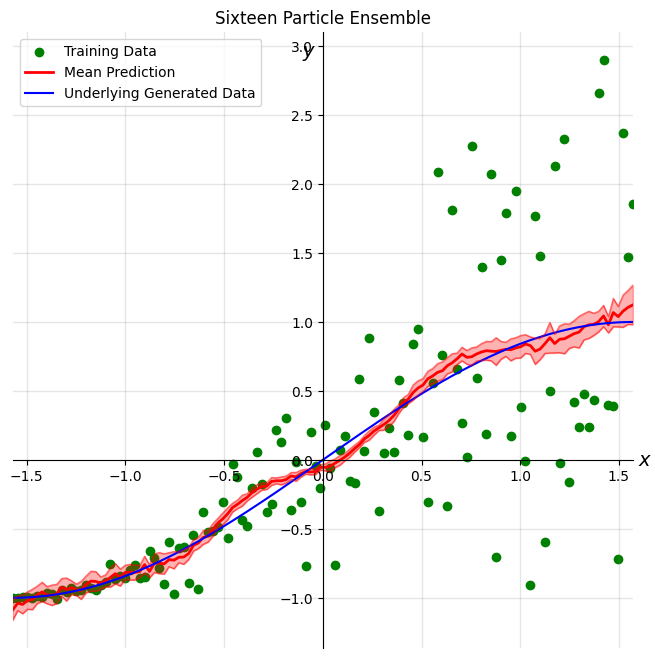

In [9]:
plot_results(dataset, sixteen_particle_outputs, 'Sixteen Particle Ensemble', in_dist=True)
plot_results(dataset, mswag_outputs, 'Sixteen Particle Multi-SWAG', in_dist=True)

#### Four and eight particle results

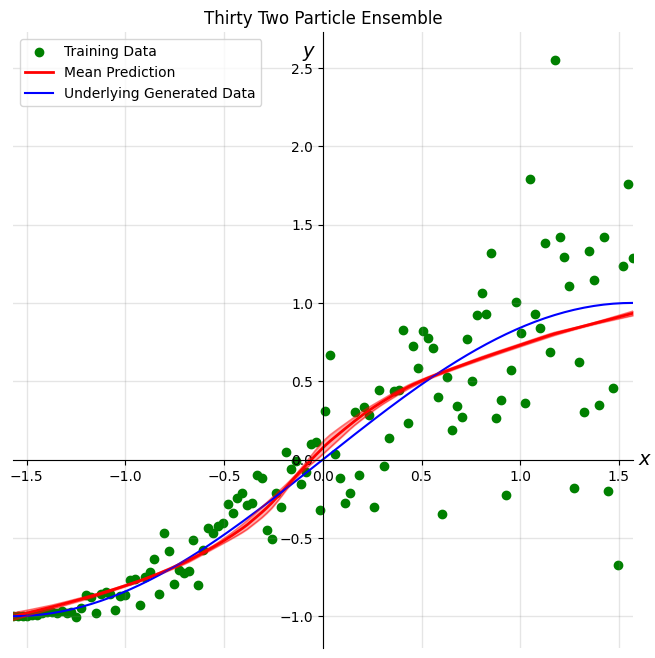

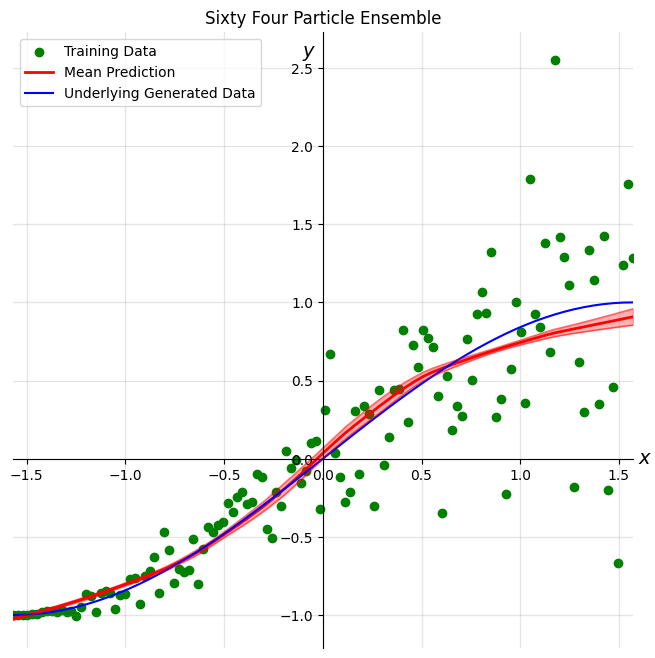

In [11]:
plot_results(dataset, thirtytwo_particle_outputs, 'Thirty Two Particle Ensemble', in_dist=True)
plot_results(dataset, sixtyfour_particle_outputs, 'Sixty Four Particle Ensemble', in_dist=True)

#### Out of Distribution Test
We set up a test dataset with the sine wave on the interval $(-2\pi, 2\pi)$ with $N = 2048$ data points. This dataset will contain inputs that are outside of the training set, specifically inputs larger than $\pi$ and smaller than $-\pi$ will be considered out of distribution data. Testing on data that is out of distribution allows us to examine the aleotoric uncertainty. Aleotoric uncertainty pertains to uncertainty present inherently within the data.

In [12]:
import numpy as np

test_begin_radians = -2 * math.pi
test_end_radians = 2 * math.pi
oos_dataset = SineWithNoiseDataset(N, D, test_begin_radians, test_end_radians)
test_dataloader = DataLoader(oos_dataset, batch_size=64, shuffle=False)

### Making Predictions from the Posterior Predictive Distribution

After training (i.e., calling `bayes_infer`), the `Ensemble` class contains the **posterior predictive** distribution. In the case of a deep ensemble, the posterior predictive distribution is approximated by the set of trained ensembles. To make predictions using the posterior predictive distribution, the `Ensemble` class provides a `posterior_pred` method.

In [13]:
sixteen_particle_oos_outputs = sixteen_particle_ensemble.posterior_pred(test_dataloader, mode=['mean', 'median', 'min', 'max', 'std'])
thirtytwo_particle_oos_outputs = thirtytwo_particle_ensemble.posterior_pred(test_dataloader, mode=['mean', 'median', 'min', 'max', 'std'])
sixtyfour_particle_oos_outputs = sixtyfour_particle_ensemble.posterior_pred(test_dataloader, mode=['mean', 'median', 'min', 'max', 'std'])

### Uncertainty

Unlike traditional DL methods which provides a single point estimate, Bayesian methods provide the ability to quantify uncertainty. There are two kinds of uncertainty.

1. **Aleoric uncertainty** is inherent in the data itself, and arises from the stochastic nature of the underlying processs for how the data was generated. In this example's dataset, the added **noise** term $\epsilon$ is the source of aleotoric uncertainty. 
2. **Epistemic uncertainty** is the uncertainty present in the model itself. Epistemic uncertainty can arise due to the lack of data. In this example, epistemic uncertainty may arise because we train the ensemble on the interval $(-2\pi, 2\pi)$, which may not be enough data to reveal the periodic nature of the sine wave. We can visualize epistemic uncertainty by plotting the **confidence interval** of predictions over our ensemble, which we do next.

### Plotting our Results

We visualize the uncertainty in our deep ensemble predictions now.

In [14]:
# def plot_results(dataset, outputs, title):
#     xs = dataset.xs
#     ys = dataset.ys

#     plt.figure(figsize=(8, 6))
#     pred_upper = outputs["mean"] + outputs["std"]
#     pred_lower = outputs["mean"] - outputs["std"]
#     plt.plot(xs, ys, c="black", label="Ground Truth")
#     plt.plot(xs, outputs["mean"], color="blue", lw=2, label="Mean Prediction")
#     plt.plot(xs, pred_upper, "-b", alpha=0.5, lw=1)
#     plt.plot(xs, pred_lower, "-b", alpha=0.5, lw=1)
#     plt.fill_between(xs.view(-1).numpy(), pred_lower.flatten(), pred_upper.flatten(), color='blue', alpha=0.3)
#     plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
#     plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
#     # plt.xlim(test_begin_radians, test_end_radians)

#     plt.ylim(-1.5, 1.5)
#     plt.title(title)
#     plt.xlabel('X')
#     plt.ylabel('Target (Y)')
#     plt.legend()
#     plt.show()
# def plot_results(dataset, outputs, title, in_dist=False):
#     xs = dataset.xs
#     ys = dataset.ys
#     fig, ax = plt.subplots(figsize=(8,8))
#     # plt.figure(figsize=(8, 6))
#     pred_upper = outputs["mean"] + outputs["std"]
#     pred_lower = outputs["mean"] - outputs["std"]
#     ax.plot(xs, ys, c="green", label="Training Data")
#     ax.plot(xs, outputs["mean"], color="olive", lw=2, label="Mean Prediction")
#     ax.plot(normal_dataset.xs, normal_dataset.ys, c = "blue", label="Underlying Generated Data")
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.spines['bottom'].set_position('zero')
#     ax.spines['left'].set_position('zero')
#     ax.set_xlabel('$x$', size=14, labelpad=-24, x=1.02)
#     ax.set_ylabel('$y$', size=14, labelpad=-21, y=.95, rotation=0)
#     ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)  
#     # plt.plot(xs, pred_upper, "-b", alpha=0.5, lw=1)
#     # plt.plot(xs, pred_lower, "-b", alpha=0.5, lw=1)
#     # plt.fill_between(xs.view(-1).numpy(), pred_lower.flatten(), pred_upper.flatten(), color='blue', alpha=0.3)
    
#     if in_dist:
#         plt.xlim(train_begin_radians, train_end_radians)
#     else:
#         plt.xlim(test_begin_radians, test_end_radians)
#         plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
#         plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
    

#     # plt.ylim(-1.5, 1.5)
#     plt.title(title)
#     # plt.xlabel('X')
#     # plt.ylabel('Target (Y)')
#     plt.legend()
#     plt.show()

#### Two particle results

In a two particle ensemble, each ensemble can form it's own predictions on the test dataset. The average prediction is given in solid blue. Both ensembles make accurate predictions when the data is within the training set (i.e., between the two vertical dashed lines). We see that when the data is outside the training data (i.e., to the left or right of the vertical dashed lines), the predictions made by both ensembles differs. The distance between the two predictions can be used to model uncertainty. Ideally, we would like the distances between different ensemble predictions to be high when it is less confident of its predictions and to be low when it is confident of its predictions. In this example, we get the desired behavior.

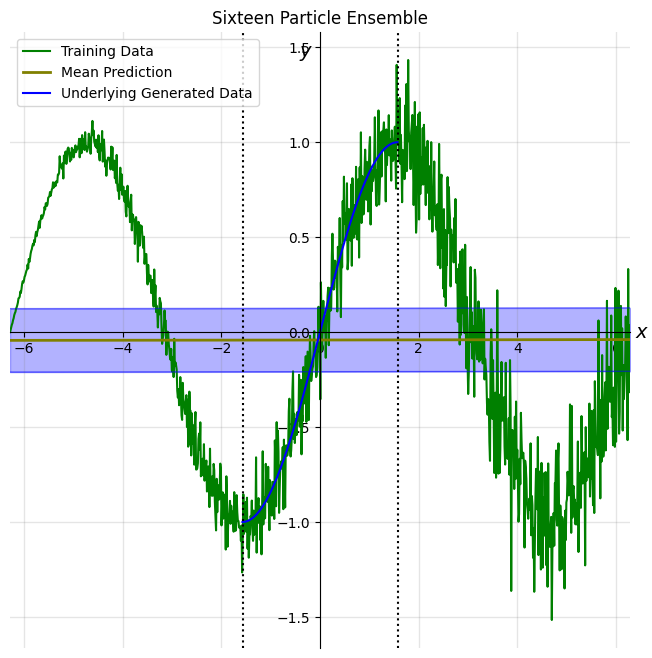

In [15]:
plot_results(oos_dataset, sixteen_particle_outputs, 'Sixteen Particle Ensemble')

#### Four and eight particle results

We can also check how four and eight particle ensembles fair.

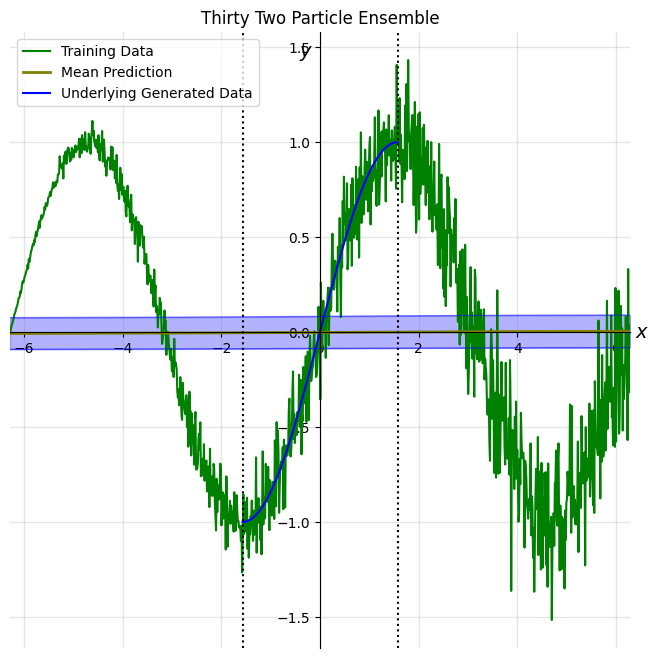

In [16]:
plot_results(oos_dataset, thirtytwo_particle_outputs, 'Thirty Two Particle Ensemble')

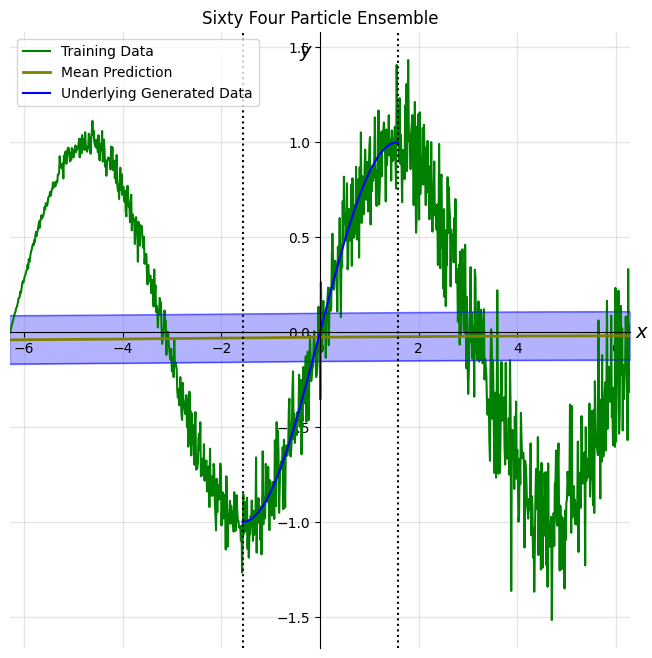

In [17]:
plot_results(oos_dataset, sixtyfour_particle_outputs, 'Sixty Four Particle Ensemble')

## Particle Scaling

While training a deep ensemble can lead to additional capabilities such as uncertainty quantification, it comes at a cost, namely increased training time. In particular, training $k$ ensembles will requires $k$ times more training time, which may be prohibitively expensive. To solve this, Push enables users to take advantage of multi-GPU hardware by managing the concurrent execution and communication between particles in a seamless manner by simply specifying the number of GPUs to use.

### Benchmarking a Simple Model

Below, we benchmark the average time per epoch for ensembles of size 2, 4, and 8 particles for 1 and 2 devices to demonstrate the scaling properties of Push on a simple model. Different models will exhibit different performance characteristics.

In [ ]:
import time

# 1. Create dataloader
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 2. Model hyperparameters
n = 5
input_dim = 1
output_dim = 1
hidden_dim = 2048
epochs = 250

def get_ensemble_time(num_ensembles, devices):
    epochs = 5
    start_time = time.time()
    push.bayes.ensemble.train_deep_ensemble(
        dataloader,
        torch.nn.MSELoss(),
        epochs,
        BiggerNN, n, input_dim, output_dim, hidden_dim,
        num_devices=devices,
        num_ensembles=num_ensembles,
        cache_size=num_ensembles/devices,
        view_size=num_ensembles/devices
    )
    end_time = time.time()
    return (end_time - start_time) / epochs

ensemble_sizes = [2, 4, 8]
one_dev_times = []
two_dev_times = []

for size in ensemble_sizes:
    one_dev_times.append(get_ensemble_time(size, 1))
    two_dev_times.append(get_ensemble_time(size, 2))

100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


### Results

We see that running Push with two devices leads to faster training times compared to running Push with one device. The ideal scaleup is a 2x speedup. The current model operates on 1 dimensional data, and thus, does not utilize the GPU effectively. Consequently, we do not achieve the ideal speedup. Different models will exhibit different performance characteristics.

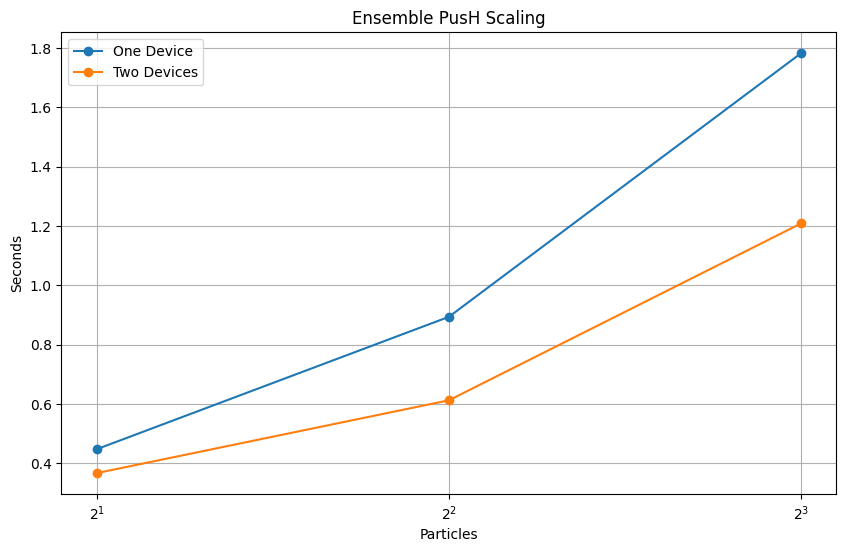

In [ ]:
import numpy as np

# Plotting
log_size = np.log2(ensemble_sizes)
plt.figure(figsize=(10, 6))
plt.plot(log_size, one_dev_times, marker='o', label='One Device')
plt.plot(log_size, two_dev_times, marker='o', label='Two Devices')
plt.title('Ensemble PusH Scaling')
plt.xlabel('Particles')
plt.ylabel('Seconds')
plt.xticks(log_size, [f'$2^{{{int(x)}}}$' for x in log_size])
plt.legend()
plt.grid(True)
plt.show()

## References

[1] Andrew Gordon Wilson and Pavel Izmailov. Bayesian deep learning and a probabilistic perspective of generalization. In Proceedings of the 34th International Conference on Neural Information Processing Systems, Neurips 2020.

[2] Kevin Murphy. Probabilistic Machine Learning: Advanced Topics. Chapter 17. MIT Press, 2023.